<a href="https://colab.research.google.com/github/chrishuskey/DS-Unit-1-Sprint-2-Statistics/blob/master/module1/Assignment_Unit_1%2C_Sprint_2%2C_Module_1_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 2 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

**1.  Load and clean the data** (or determine the best method to drop observations when running tests)

In [0]:
# Get the US Congress House votes data from UCI:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-10-08 21:16:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.2’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.04s   

2019-10-08 21:16:14 (449 KB/s) - ‘house-votes-84.data.2’ saved [18171/18171]



In [0]:
# Look at what the dataset looks like in raw form first:
!head house-votes-84.data

republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
democrat,n,y,n,y,y,y,n,n,n,n,n,n,?,y,y,y
republican,n,y,n,y,y,y,n,n,n,n,n,n,y,y,?,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,?,?


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a Pandas dataframe for this dataset, so we can work with it more:
column_names = [
                'party', 
                'handicapped-infants', 
                'water-project-cost-sharing', 
                'budget_adoption', 
                'physician-fee-freeze', 
                'el-salvador-aid', 
                'religious-groups-in-schools', 
                'anti-satellite-test-ban', 
                'aid-to-nicaraguan-contras', 
                'mx-missile', 
                'immigration', 
                'synfuels-corporation-cutback', 
                'education-spending', 
                'superfund-right-to-sue', 
                'crime', 
                'duty-free-exports', 
                'south-africa-export-administration-act'
                ]

US_congress_votes = pd.read_csv('house-votes-84.data', header=None, names=column_names)

In [0]:
# Make a copy with original text values that show us what the actual values are:
votes_TEXT = US_congress_votes.copy()

# Replace the '?' values throughout the dataset, which stand for 
# (a) voted 'present' only (but no yes/no vote) or (b) abstained (did not vote):
votes_TEXT = votes_TEXT.replace({'?': 'abstained'})

# Change main dataset to numbers (binary 0/1) and NaN values, so we can work with it:
US_congress_votes = US_congress_votes.replace({'?': np.NaN, 'n': 0, 'y': 1})

In [0]:
print('Shape of df:', US_congress_votes.shape)
US_congress_votes.head()

Shape of df: (435, 17)


,party,handicapped-infants,water-project-cost-sharing,budget_adoption,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,south-africa-export-administration-act
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
# Count NaNs (abstained), since df.decribe() won't show us these:
US_congress_votes.isnull().sum()

party                                       0
handicapped-infants                        12
water-project-cost-sharing                 48
budget_adoption                            11
physician-fee-freeze                       11
el-salvador-aid                            15
religious-groups-in-schools                11
anti-satellite-test-ban                    14
aid-to-nicaraguan-contras                  15
mx-missile                                 22
immigration                                 7
synfuels-corporation-cutback               21
education-spending                         31
superfund-right-to-sue                     25
crime                                      17
duty-free-exports                          28
south-africa-export-administration-act    104
dtype: int64

In [0]:
# Check to make sure all observations (congresspeople) belong to either the 
# Republican party or Democratic party (is Bernie not in this dataset?...):
US_congress_votes['party'].value_counts(dropna=False)

democrat      267
republican    168
Name: party, dtype: int64

In [0]:
# Create separate Republicans-only and Democrats-only dataframes to work with:
republicans = US_congress_votes[US_congress_votes['party'] == 'republican']
democrats = US_congress_votes[US_congress_votes['party'] == 'democrat']

In [0]:
republicans.describe()

,handicapped-infants,water-project-cost-sharing,budget_adoption,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,south-africa-export-administration-act
count,165.000000,148.000000,164.000000,165.000000,165.000000,166.000000,162.000000,157.000000,165.000000,165.000000,159.000000,155.000000,158.000000,161.000000,156.000000,146.000000
mean,0.187879,0.506757,0.134146,0.987879,0.951515,0.897590,0.240741,0.152866,0.115152,0.557576,0.132075,0.870968,0.860759,0.981366,0.089744,0.657534
std,0.391804,0.501652,0.341853,0.109760,0.215442,0.304104,0.428859,0.361010,0.320176,0.498186,0.339643,0.336322,0.347298,0.135649,0.286735,0.476168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
democrats.describe()

,handicapped-infants,water-project-cost-sharing,budget_adoption,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,south-africa-export-administration-act
count,258.000000,239.000000,260.000000,259.000000,255.000000,258.000000,259.000000,263.000000,248.000000,263.000000,255.000000,249.000000,252.000000,257.000000,251.000000,185.000000
mean,0.604651,0.502092,0.888462,0.054054,0.215686,0.476744,0.772201,0.828897,0.758065,0.471483,0.505882,0.144578,0.289683,0.350195,0.637450,0.935135
std,0.489876,0.501045,0.315405,0.226562,0.412106,0.500430,0.420224,0.377317,0.429121,0.500138,0.500949,0.352383,0.454518,0.477962,0.481697,0.246956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
from scipy.stats import ttest_1samp, ttest_ind

**2.  Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01**

In [0]:
# Budget adoption bill for that year, 2-sample t-test:
# n0:  Republicans' and Democrats' support for this bill was not different.
# Test result:  Reject n0.  Democrats supported this bill much more than 
# Republicans did (p < 0.01 by a lot for the 2-sample t-test).
ttest_ind(democrats['budget_adoption'], republicans['budget_adoption'], nan_policy='omit')

Ttest_indResult(statistic=23.21277691701378, pvalue=2.0703402795404463e-77)

**3.  Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01**

In [0]:
# Education Spending bill, 2-sample t-test:
# n0:  Republicans' and Democrats' support for this bill was not different.
# Test result:  Reject n0.  Republican support and Democrat support for this 
# bill was statistically different (p < 0.01 by a lot for the 2-sample t-test).
ttest_ind(republicans['education-spending'], democrats['education-spending'], nan_policy='omit')

Ttest_indResult(statistic=20.500685724563073, pvalue=1.8834203990450192e-64)

In [0]:
# Make copies with no NaNs, for plotting:
reps_no_NaNs = republicans.copy().dropna()
dems_no_NaNs = democrats.copy().dropna()

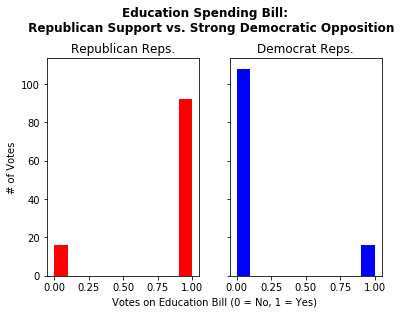

In [0]:
# Let's visualize this to see if their probability distributions (PDFs) make this clear too:
fig, (reps, dems) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Education Spending Bill:  \n Republican Support vs. Strong Democratic Opposition', fontweight='bold', x=0.5, y=1.06)
reps.hist(reps_no_NaNs['education-spending'], color='red')
reps.set_title('Republican Reps.')
reps.set_xlabel('Votes on Education Bill (0 = No, 1 = Yes)', x=1.1)
reps.set_ylabel('# of Votes')
dems.hist(dems_no_NaNs['education-spending'], color='blue')
dems.set_title('Democrat Reps.')
plt.show()

**4.  Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1** (i.e. there may not be much of a difference)

In [0]:
# Water Project Cost Sharing Bill, 2-sample t-test:  
# n0:  Republicans' and Democrats' support for this bill was not different.
# Test result:  We FAIL to reject the n0 that they are the same 
# (p !< 0.01 for the 2-sample t-test).
ttest_ind(republicans['water-project-cost-sharing'], democrats['water-project-cost-sharing'], nan_policy='omit')

Ttest_indResult(statistic=0.08896538137868286, pvalue=0.9291556823993485)

Additional HW to do's from Aaron (added during lecture):

In [0]:
# HW:  To do (Aaron from lecture):  Do more exploration/soak and poke the data, draw plots:
# See above!

In [0]:
# HW:  To do (Aaron from lecture):  
# Homework null hypothesis - republicans and dems support the 'handicapped-infants bill equally:

# Use a 2-sample t-test, because comparing 2 different samples.
# Note:  The built-in null hypothesis for a 2-sample t-test is that the two 
# sample populations are statistically equal -- i.e., n0: Reps.' and Dems.' 
# support for this bill is equal:

# As show below, we reject this null hypothesis (and p < 0.01 by a lot): 
# Republicans and Democrats do NOT support this bill equally -- must be some alternate hypothesis at work here.
ttest_ind(republicans['handicapped-infants'], democrats['handicapped-infants'], nan_policy='omit')

Ttest_indResult(statistic=-9.205264294809222, pvalue=1.613440327937243e-18)